# Object Detection

This notebook will go over how to do object detection in fastai 2.0. We will use the Retina-Net architecture and the `COCO_TINY` dataset. First let's install the library as usual

In [0]:
import os

In [0]:
!pip install torch torchvision feather-format kornia pyarrow Pillow wandb --upgrade 
!pip install git+https://github.com/fastai/fastai_dev
os._exit(00)

Now let's grab our vision imports. Along with this I have prepared an import for object detection (specifically Single-Shot-Detection with RetinaNet) on my repo. The below code will import what you need

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [0]:
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0"
from imports.object_detection import *

And grab our data

In [0]:
coco_source = untar_data(URLs.COCO_TINY)

If we look, we can find that our labels in a `json` are in `train.json`, and our images in `train`

In [5]:
coco_source.ls()

(#2) [/root/.fastai/data/coco_tiny/train,/root/.fastai/data/coco_tiny/train.json]

The library has a `get_annotations` function, which we can use to grab our images and the corresponding bounding boxes, "Open a COCO style json in `fname` and returns the lists of filenames (with maybe `prefix`) and labelled bboxes."

In [0]:
imgs, lbl_bbox = get_annotations(coco_source/'train.json')

In [7]:
imgs[:1]

['000000542959.jpg']

In [8]:
lbl_bbox[:1]

[([[32.52, 86.34, 41.050000000000004, 95.75],
   [98.12, 110.52, 100.07000000000001, 114.59],
   [91.28, 51.62, 95.23, 57.339999999999996],
   [110.48, 110.82, 125.03, 126.03999999999999],
   [96.63, 50.18, 115.3, 63.64],
   [0.69, 111.73, 12.49, 124.79]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair'])]

The last thing we need to do is make a dictionary of our images to their corresponding labels

In [0]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [10]:
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'000000542959.jpg': ([[32.52, 86.34, 41.050000000000004, 95.75],
   [98.12, 110.52, 100.07000000000001, 114.59],
   [91.28, 51.62, 95.23, 57.339999999999996],
   [110.48, 110.82, 125.03, 126.03999999999999],
   [96.63, 50.18, 115.3, 63.64],
   [0.69, 111.73, 12.49, 124.79]],
  ['chair', 'vase', 'vase', 'chair', 'chair', 'chair'])}

Next bit is to make our `DataBlock`. As we are doing Bounding Boxes, we will have **three** blocks, an `ImageBlock`, `BBoxBlock`, and a `BBoxLblBlock`. The last two are for our output bounding boxes.

We will also need a getter. `noop` is a function that will do nothing. We will also need to grab the first and second part of a particular name and bounding box coordinates from our img2bbox function, and declare our number of inputs (which is 1)


In [0]:
getters = [noop, lambda o: img2bbox[o.name][0],  lambda o: img2bbox[o.name][1]]

In [0]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items = get_image_files,
                 splitter=RandomSplitter(),
                 getters=getters,
                 n_inp=1)

In [0]:
dbunch = coco.databunch(coco_source, item_tfms=Resize(128),
                        batch_tfms=aug_transforms())

In [14]:
dbunch.bs

16

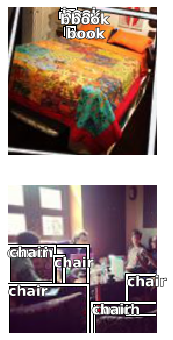

In [15]:
dbunch.show_batch(max_n=2)

# Model

Now let's get to our architecture. For this we will use a pretrained resnet34 and apply a custom head (through a call to RetinaNet) on top to do our bounding boxes

In [0]:
arch = resnet34

Let's cut off the head of our model so we can apply our new head

In [0]:
encoder = create_body(arch, cut=-2)

Lastly we need to call `RetinaNet` to grab our architecture. We need to pass in our encoder, how many classes we have (we can use `get_c` to grab the number of classes) and what we want our bias to be on the last convolutional layer (how we initialize it). Jeremy has a -4 so let's do that!

In [0]:
model = RetinaNet(encoder, get_c(dbunch), final_bias=-4)

The main difference between `RetinaNet` and our regular model is (mostly) how the head looks. Instead of our regular head where it is a bunch of Linear layers with Pooling like so:

In [42]:
create_head(124, 4)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=124, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=512, out_features=4, bias=True)
)

We will use a head which consistes a smoother, a classifier, and a box_regressor (to get our box points)

In [45]:
model.smoothers

ModuleList(
  (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [46]:
model.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [47]:
model.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Now we can move onto our loss function. For `RetinaNet` to work, we need to define what the aspect ratio's and scales of our image should be. The paper used `[1,2**(1/3), 2**(2/3)]`, but they also used an image size of 600 pixels, so even the largest feature map (box) gave anchors that covered less than the image. But for us it would go over. As such we will use -1/3 and -2/3 instead. We will need these for inference later!

In [0]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 

Let's generate our loss function, which is `RetinaNetFocalLoss`

In [0]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

Now let's make our `Learner`! 

In [0]:
learn = Learner(dbunch, model, loss_func=crit)

As we are using a pre-trained backbone (our resnet34) we want to freeze our layers. (`cnn_learner` will do this automatically)

In [0]:
learn.freeze()

Let's find that learning rate and train!

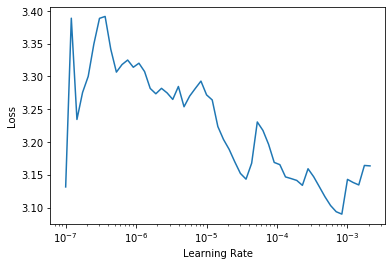

In [63]:
learn.lr_find()

In [64]:
learn.fit_one_cycle(20, slice(9e-5, 7e-5))

epoch,train_loss,valid_loss,time
0,3.184801,3.163619,00:02
1,3.039300,2.924439,00:02
2,2.997916,2.813874,00:02
3,2.896903,3.916539,00:02
4,2.800470,3.011235,00:02
5,2.725802,2.610097,00:02
6,2.641438,2.646170,00:02
7,2.560639,2.988424,00:02
8,2.481499,2.701625,00:02
9,2.425536,2.533309,00:02


In [0]:
learn.save('sample')

In [0]:
learn.load('sample');

Now let's unfreeze the rest of our model and train a bit more

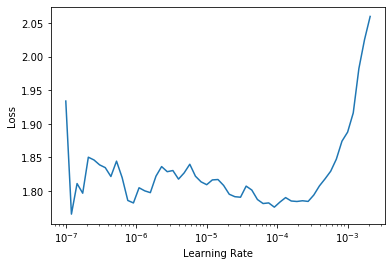

In [67]:
learn.unfreeze()
learn.lr_find()

Since we unfroze our model, we only pass in one learning rate now

In [69]:
learn.fit_one_cycle(10, 3e-5)

epoch,train_loss,valid_loss,time
0,1.816928,2.527726,00:02
1,1.816838,2.582552,00:02
2,1.811184,2.614970,00:02
3,1.795112,2.580782,00:02
4,1.761387,2.608566,00:02
5,1.765157,2.675946,00:02
6,1.770589,2.567394,00:02
7,1.737667,2.626663,00:02
8,1.731346,2.621664,00:02
9,1.720024,2.635611,00:02


In [0]:
learn.save('fine-tuned')

# Inference

Since our output is two different blocks, this is currently not supported yet (but will be soon!) In the meantime let's walk through how you would do this

In [0]:
learn.load('fine-tuned');

First we need to grab an image to use that is a tensor (we'll use the first one in our validation dataset)

In [0]:
img, y1, y2 = next(iter(dbunch.valid_dl))

And now to grab our predictions we call `torch.no_grad()` and pass in our tensor

In [0]:
with torch.no_grad():
  output = learn.model(img)

Since we used the first image in our validation dataset, let's grab the real image

In [0]:
idx = 0
img = dbunch.valid_ds[idx][0]

We will also need to know the classes we are using. These live in `dbunch.vocab`

In [72]:
classes = dbunch.vocab; classes

(#7) [#na#,book,chair,couch,remote,tv,vase]

Lastly we can make a call to `show_preds`. This lives in the `inference.py` file. We need to pass in our input image, the output of our model, the index it was at, the scales and ratios we determined earlier, a ratio for detection, and our classes we used

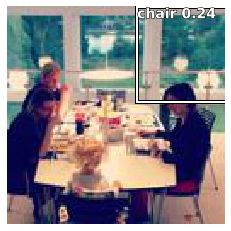

In [73]:
show_preds(img, output, idx, scales, ratios, detect_thresh=0.23, classes=classes)

If you get a warning saying:

`RuntimeError: cannot perform reduction function max on tensor with no elements because the operation does not have an identity`

This is becuse your threshold is too high, try bringing it down

This model is clearly not the best, but we gave it such a small training set that it makes sense to do so. Hope this tutorial helps!